## Мудрость 

> Помните, что для человека звук его имени является самым сладким и самым важным звуком человеческой речи. (Дейл Карнеги)

Доверяй, но проверяй. Решим задачку по психологии! Все цитаты в пабликах вконтакте делятся на два вида: мудрые и недостаточно мудрые. Если цитата мудрая, то её можно лайкнуть. Поговаривают, что если в цитате есть личные местоимения, то пользователь автоматически сопоставляет себя автору этой цитаты и вероятность того, что она будет лайкнута, повышается. Например, цитату 

> Можно простить человеку все, кроме отсутствия. (Экзюпери) 

мне не очень хотелось бы лайкать. А вот цитата 

> Мне наплевать, что вы обо мне думаете. Я о вас вообще не думаю. (Булгаков) 

совершенно другое дело. 

В табличке `df_vk_wise` лежат данные о мудрых цитатах из [мудрого паблика.](https://vk.com/ooioioioioioo) В колонке `I` находится переменная, которая принимает значение `True`, когда в тексте цитаты было личное местоимение "Я".

Срежем первые $50$ постов, так как под ними количество репостов и лайков ещё окончательно не выставлено, и будем работать с остатками. 

In [1]:
import numpy as np
import pandas as pd

from scipy import stats as sts

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

df = pd.read_csv('data/df_vk_wise.csv')[50:]
df.head()

,likes,reposts,text,I
50,549,25,"Я, говорит, люблю человечество, но дивлюсь на ...",True
51,607,22,"Нельзя любить то, что я люблю, да ещё так, как...",True
52,914,37,Если испытываешь по-настоящему глубокое чувств...,False
53,989,34,"— Я тебя люблю, — сказал я. \r\n— Это пройдет,...",True
54,1229,32,"Он очаровательно рассказывает мне о том, как о...",False


Гистограммы для числа лайков постов, содержащих личные местоимения и не содержащих:

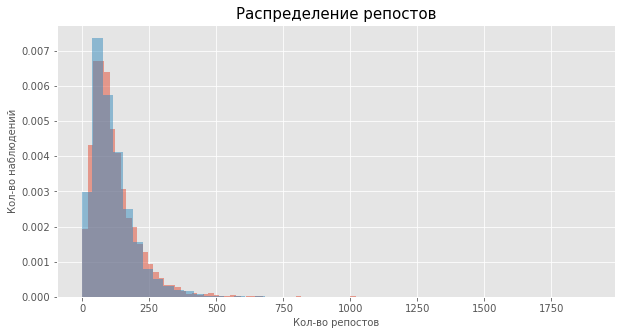

In [2]:
plt.figure(figsize=(10, 5))
plt.hist(df.loc[df['I'], 'reposts'].values, density=True, bins=50, alpha=0.5, label='with I')
plt.hist(df.loc[~df['I'], 'reposts'].values, density=True, bins=50, alpha=0.5, label='without I');
plt.title('Распределение репостов', size=15)
plt.xlabel('Кол-во репостов', size=10)
plt.ylabel('Кол-во наблюдений', size=10);

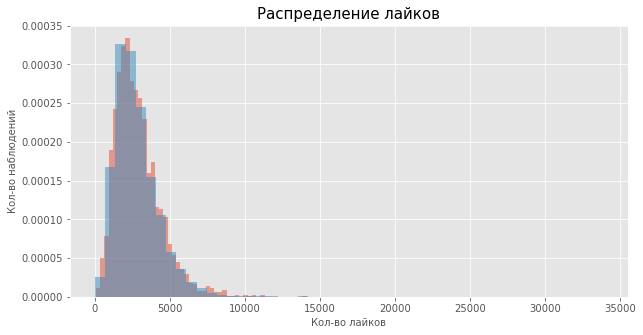

In [3]:
plt.figure(figsize=(10, 5))
plt.hist(df.loc[df['I'], 'likes'].values, density=True, bins=50, alpha=0.5, label='with I')
plt.hist(df.loc[~df['I'], 'likes'].values, density=True, bins=50, alpha=0.5, label='without I');
plt.title('Распределение лайков', size=15)
plt.xlabel('Кол-во лайков', size=10)
plt.ylabel('Кол-во наблюдений', size=10);

Да, проблемы есть. Это выбросы. Хвосты на гистограммах оказываются очень длинными. Найдем медианы и средние для числа лайков. 

In [4]:
likes = df['likes'].values
mean_likes = df['likes'].mean()
median_likes = df['likes'].median()

print(f"mean number of likes: {mean_likes:.2f} > median number of likes: {median_likes:.0f}")

mean number of likes: 2810.76 > median number of likes: 2524


Проверим гипотезу о равенстве среднего числа лайков. Используем для этого $z$-тест, основанный на ЦПТ. Дисперсию расчитываем по выборке, используя несмещённую оценку `(ddof=1)`.

Гипотеза:

$H_0: \mu_{withI} - \mu_{withoutI} = 0$

$H_a: \mu_{withI} - \mu_{withoutI} \neq 0$



In [5]:
alpha = 0.05

withI = df.loc[df['I'], 'likes'].values
n_withI = withI.size
mean_withI = withI.mean()
var_withI = withI.var(ddof=1)

withoutI = df.loc[~df['I'], 'likes'].values
mean_withoutI = withoutI.mean()
n_withoutI = withoutI.size
var_withoutI = withoutI.var(ddof=1)

z_obs = (mean_withI - mean_withoutI - 0) / np.sqrt((var_withI / n_withI) + (var_withoutI / n_withoutI))

In [6]:
z_crit = sts.norm.ppf(1 - alpha)
pval = 2 * (1 - sts.norm().cdf(np.abs(z_obs)))

print(f'''Наблюдаемое значение {z_obs:.2f} больше критического {z_crit:.2f} (эквивалентно: p-value = {pval:.2f} < 0.05) => 
=> нулевая гипотеза отвергается''')


Наблюдаемое значение 2.66 больше критического 1.64 (эквивалентно: p-value = 0.01 < 0.05) => 
=> нулевая гипотеза отвергается


**Вывод:** нулевую гипотезу о равенстве средних с "Я" и без "Я" можно отвергнуть. Следовательно, действительно в среднем количество лайков у цитат с Я отличается от количества лайков у цитат без Я. 

Можно заметить, что у распределения числа репостов длинные хвосты. В данных есть выбросы, которые завышают среднее значение. Если выбросы сильные, то ЦПТ может ломаться. Из-за этого имеет смысл в данном случае использовать другой критерий. Например, критерий Манна-Уитни.


$H_0: f_{withI}(x) = f_{withoutI}(x)$

$H_a: f_{withI}(x) = f_{withoutI}(x + \Delta), \Delta > 0$

In [7]:
u_obs = sts.mannwhitneyu(withI, withoutI)[0]
pvalMW = sts.mannwhitneyu(withI, withoutI)[1]

print(f"наблюдаемое значение статистики Манна-Уитни: {u_obs:.2f}")
print(f"p-value критерия Манна-Уитни: {pvalMW:.2f}")



наблюдаемое значение статистики Манна-Уитни: 8604129.50
p-value критерия Манна-Уитни: 0.01


**Вывод:** нулевую гипотезу об отсутствии сдвига распределения количества лайков с "Я" и без "Я" можно отвергнуть. Следовательно, действительнов в среднем количество лайков у цитат с Я отличается от количества лайков у цитат без Я. Результат тот же, что получился у z-теста, вероятно потому что выбросы присутствовали в обоих выборках, а значит среднее завышалось +- одинаково из-за них. В критерии Манна-Уитни мы сделали предположение об одинаковом распределении выборок, однако этот факт тоже необходимо бы статистически проверить.

*Тест М-У очень быстро сходится по вероятности к стандартному нормальному распределению. В самом тесте сравнивается не $U$-статистика, указанная в первой строке выше, а $\frac{U - E(U)}{\sqrt{Var(U)}}$ с критическим значением, которая в реализации sts.mannwhitneyu берется из нормального*

Проверим гипотезу о мудрости с помощью бутстрапа

Гипотеза:

$H_0: Med_{withI}(x) - Med_{withoutI}(x) = 0$

$H_a: Med_{withI}(x) - Med_{withoutI}(x) \neq 0$



In [8]:
def get_bootstrap_sample(x, B=1):
    N = x.size
    sample = np.random.choice(x, size=(N, B), replace=True)
    
    if B == 1:
        sample = sample.T[0]
        
    return sample

withI_boot = get_bootstrap_sample(withI, B=10000)
withoutI_boot = get_bootstrap_sample(withoutI, B=10000)

withI_boot_med = np.median(withI_boot, axis=0)
withoutI_boot_med = np.median(withoutI_boot, axis=0)

In [9]:
def stat_intervals(boot, alpha=0.05):
    left = np.quantile(boot, alpha/2)
    right = np.quantile(boot, 1-alpha/2)
    return left, right

print(f"95%-ный доверительный интервал: {stat_intervals(withI_boot_med - withoutI_boot_med)}")

95%-ный доверительный интервал: (12.0, 172.0)


**Ответ:**

Нулевая разница между медианами не принадлежит построенному доверительному интервалу => значит  отличия между медианами лайков с Я и без Я статистически значимы на 5%-м уровне значимости => бутстрап подтведил гипотезу о мудрости цитат с Я
